In [1]:
import pandas as pd
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('data/data_p.csv')

In [3]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
data.drop_duplicates(subset=['id'], inplace=True)

In [15]:
data = data.reset_index(drop=True)

In [ ]:
# merge_dicts = lambda ds: reduce(lambda d1, d2: d1 + d2, [eval(d) for d in ds])
# data = data.groupby('id', as_index=False).agg({
#     'cat_feature': 'first',
#     'metrics': merge_dicts,
#     'dt_diff': 'first'
# })

In [13]:
data.drop(data.index[[31102]], inplace=True)

In [8]:
# find frequency of keys in metrics
freq_keys = {}
for i in range(data.shape[0]):
    try:
        for k in eval(data.at[i, 'metrics']).keys():
            if k not in freq_keys:
                freq_keys[k] = 0
            freq_keys[k] += 1
    except NameError:
        print(i)

31102


In [16]:
# get top 10 as new features
new_features = sorted(freq_keys, key=freq_keys.get, reverse=True)[:100]

In [17]:
for f in new_features:
    data[f] = 0

In [18]:
# add 10 new features to data
for i in range(data.shape[0]):
    metrics = eval(data.at[i, 'metrics'])
    for k in new_features:
        if k in metrics:
            inc = metrics[k]
        else:
            inc = 0
        data.at[i, k] += inc

In [21]:
data.drop('metrics', axis=1, inplace=True)

In [22]:
data['cat_feature'] = data['cat_feature'].astype(float)
data['dt_diff'] = data['dt_diff'].astype(float)

In [40]:
data.describe()

,cat_feature,dt_diff,809001,2812609,219266,834560,2136794,1376123,1965842,1346833,...,374261,500613,73530,479646,510616,308474,1420376,277312,382226,552308
count,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,...,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000,609018.000000
mean,3.495684,30.126388,63.974569,8.687045,3.893926,25.421777,7.793743,10.314982,6.965702,3.371211,...,1.068752,1.510652,1.211777,1.603335,1.798298,0.728113,0.879659,0.678046,1.106136,2.008901
std,1.641125,8.617177,106.714119,20.040482,9.225874,68.527183,26.344550,36.549536,23.169663,9.318458,...,7.592742,9.408786,8.490243,11.523659,10.732252,2.932385,9.029383,3.433871,7.541020,11.984332
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,27.060000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,30.385965,24.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,33.333333,79.000000,9.000000,4.000000,18.000000,5.000000,6.000000,4.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,60.000000,3213.000000,1300.000000,1767.000000,2419.000000,2309.000000,2902.000000,1421.000000,1172.000000,...,1658.000000,1479.000000,1503.000000,2853.000000,1466.000000,436.000000,2197.000000,618.000000,855.000000,1706.000000


In [24]:
train_answers = pd.read_csv('data/train_answers.tsv', sep='\t')
train_answers.columns = ['id', 'target']

In [60]:
# join data with target
merged_data = pd.merge(data, train_answers, on=['id'])
merged_data.drop('id', axis=1, inplace=True)

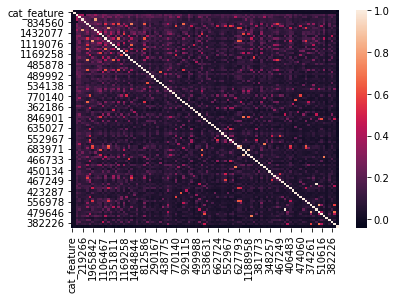

In [27]:
sns.heatmap(merged_data.corr());

In [ ]:
# normalization
f = merged_data['cat_feature']
merged_data['cat_feature'] = (f - f.mean()) / f.std()
f = merged_data['dt_diff']
merged_data['dt_diff'] = (f - f.mean()) / f.std()

Build very simple baseline model for predicting target on test data

In [61]:
# split merged_data to data & target
target = merged_data['target'].values
merged_data.drop('target', axis=1, inplace=True)

In [62]:
from sklearn import preprocessing

x = merged_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
merged_data = pd.DataFrame(x_scaled)

In [63]:
X_train, X_cv, y_train, y_cv = train_test_split(merged_data.values, target, test_size=0.3, random_state=17)

In [64]:
from sklearn.neural_network import MLPClassifier 

model = MLPClassifier(hidden_layer_sizes=(15, 15, 15))
# fit model and get predictions
model.fit(X_train, y_train)
trainPredict = model.predict_proba(X_train)
testPredict = model.predict_proba(X_cv)

In [51]:
model = LogisticRegression()

In [52]:
# fit model and get predictions
model.fit(X_train, y_train)
trainPredict = model.predict_proba(X_train)
testPredict = model.predict_proba(X_cv)

In [65]:
# leave only positive results
trainPredict = trainPredict[:,1]
testPredict = testPredict[:,1]

In [66]:
print("train ROC AUC score =", roc_auc_score(y_train, trainPredict))
print("test ROC AUC score =", roc_auc_score(y_cv, testPredict))

train ROC AUC score = 0.6255230289499503
test ROC AUC score = 0.6106814766794015


In [67]:
# download & process test
test = pd.read_csv('data/test.tsv', sep='\t')
test.columns = ['id']

In [68]:
# join data with test
merged_data = pd.merge(data, test, how='right', on=['id'])
merged_data.drop('id', axis=1, inplace=True)

In [69]:
x = merged_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
merged_data = pd.DataFrame(x_scaled)

In [70]:
# make prediction on test data
prediction = model.predict_proba(merged_data)[:,1]

In [71]:
# write prediction to output file
prd = pd.DataFrame(data=prediction)
prd.to_csv('prd.csv', index=None, header=None)